# Configuration

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
sampling_rate = 100
dataset_path = "ecg_dataset/"

# Preparing data for training

In [3]:
from scripts.data_preparation import get_data_ready_for_training

(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test,
    multi_label_binarizer,
) = get_data_ready_for_training(
    dataset_path=dataset_path,
    sampling_rate=100,
    use_tsfel=True,
    use_temporal_features=True,
    scale_features=True,
    train_val_split=False,
)

Loaded labels
Loaded ECG signals
Encoded labels
*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Extracted features
Scaled ECG signals


# Adapted algorithms

## MLkNN (Multilabel k Nearest Neighbours)

In [4]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

mlknn_parameters = {"k": range(1, 5), "s": [0.5, 0.7, 1.0]}
score = "f1_macro"

mlknn_cv = GridSearchCV(
    estimator=MLkNN(),
    param_grid=mlknn_parameters,
    scoring=score,
    verbose=2,
    error_score="raise",
)

## MLkNN model training

In [5]:
mlknn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.1s
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.2s
[CV] END .........................................k=1, s=0.5; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.2s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=0.7; total time=   2.1s
[CV] END .........................................k=1, s=1.0; total time=   2.2s
[CV] END .......................................

GridSearchCV(error_score='raise', estimator=MLkNN(),
             param_grid={'k': range(1, 5), 's': [0.5, 0.7, 1.0]},
             scoring='f1_macro', verbose=2)

In [6]:
mlknn_cv.best_params_

{'k': 2, 's': 0.5}

## MLkNN model saving

In [8]:
import os
from joblib import dump

mlknn_model = mlknn_cv.best_estimator_
mlknn_model_filename = "mlknn.joblib"
output_directory = f"saved_models/mlknn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

mlknn_model_path = os.path.join(output_directory, mlknn_model_filename)

dump(
    value=mlknn_model,
    filename=mlknn_model_path,
)

['saved_models/mlknn/mlknn.joblib']

## Model evaluation

In [9]:
y_pred_mlknn_proba = mlknn_model.predict_proba(X_test).toarray()

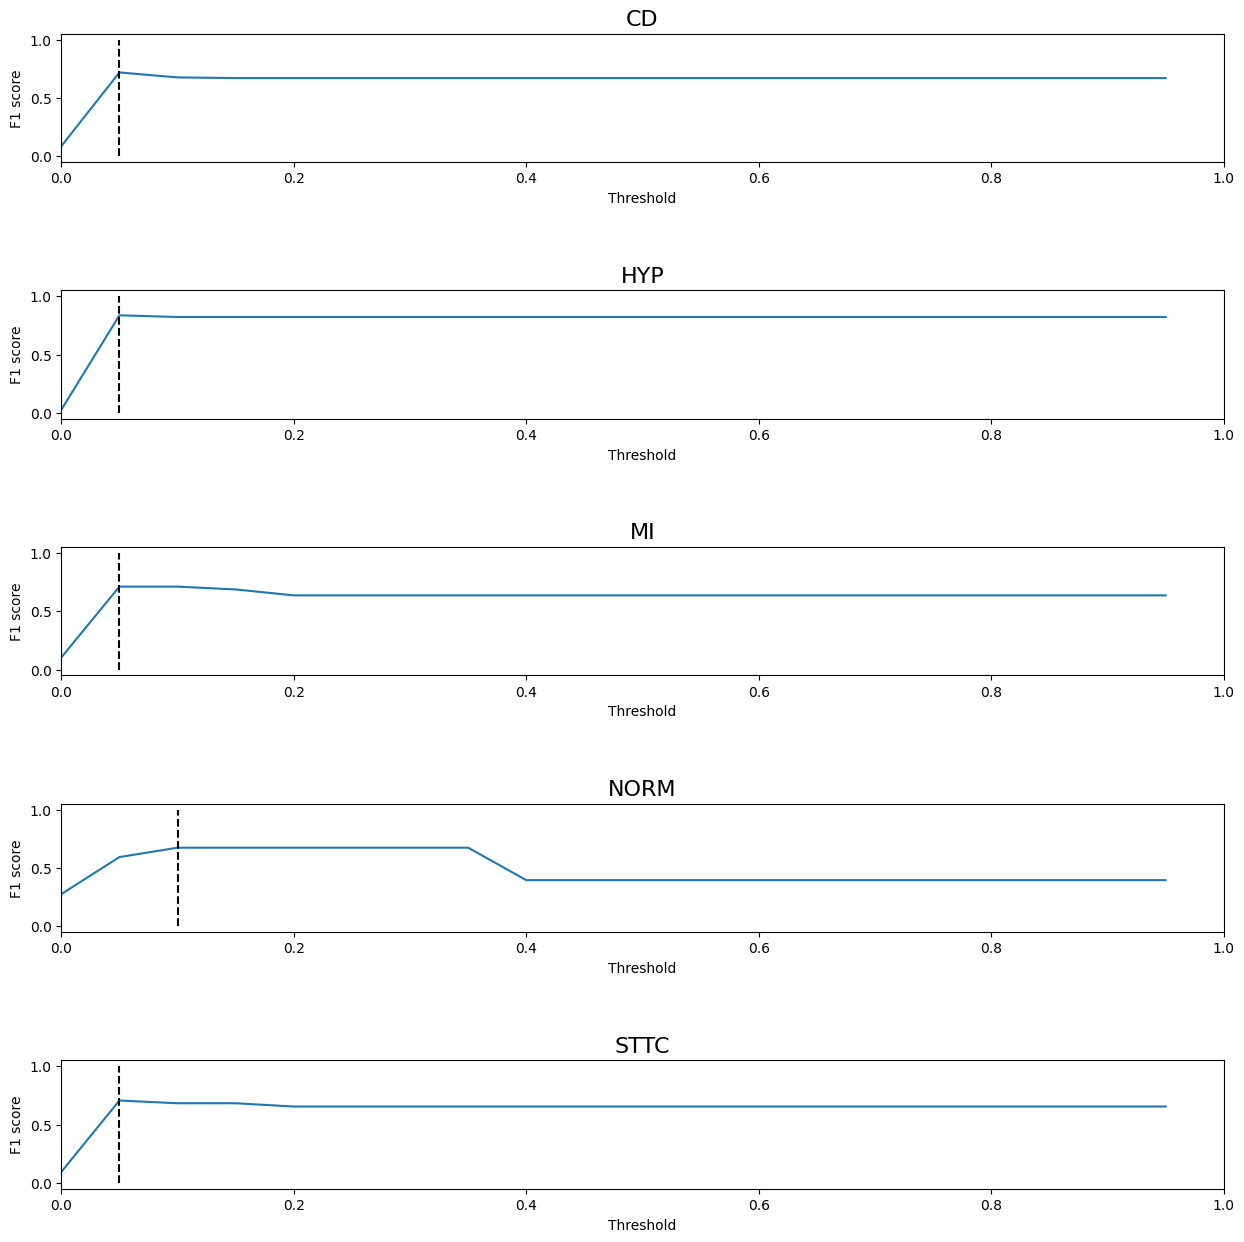

In [10]:
from scripts.data_evaluation import plot_optimal_thresholds

file_name = "optimal_thresholds.png"
output_directory = f"optimal_thresholds_visualizations/mlknn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

mlknn_optimal_thresholds = plot_optimal_thresholds(
    y_test, y_pred_mlknn_proba, file_path=os.path.join(output_directory, file_name)
)

In [18]:
y_pred_mlknn = mlknn_model.predict(X_test).toarray()
# y_pred_mlknn = (mlknn_model.predict_proba(X_test).toarray() > mlknn_optimal_thresholds) * 1

In [19]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf

file_name = "model_evaluation.csv"
output_directory = f"saved_data/mlknn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

binary_crossentropy_loss_mlknn = tf.keras.losses.BinaryCrossentropy()
loss_mlknn = binary_crossentropy_loss_mlknn(y_test, y_pred_mlknn_proba)

binary_accuracy_mlknn = tf.keras.metrics.BinaryAccuracy()
_ = binary_accuracy_mlknn.update_state(y_test, y_pred_mlknn)

recall_mlknn = tf.keras.metrics.Recall()
_ = recall_mlknn.update_state(y_test, y_pred_mlknn)

precision_mlknn = tf.keras.metrics.Precision()
_ = precision_mlknn.update_state(y_test, y_pred_mlknn)

auc_mlknn = tf.keras.metrics.AUC(multi_label=True)
_ = auc_mlknn.update_state(y_test, y_pred_mlknn)

mlknn_model_evaluation = np.array(
    [
        loss_mlknn.numpy(),
        binary_accuracy_mlknn.result().numpy(),
        recall_mlknn.result().numpy(),
        precision_mlknn.result().numpy(),
        auc_mlknn.result().numpy(),
    ]
)
mlknn_model_evaluation = np.round(mlknn_model_evaluation, 3)
mlknn_model_evaluation_df = pd.DataFrame(
    data=mlknn_model_evaluation,
    index=["loss", "binary_accuracy", "recall", "precision", "auc"],
).transpose()
mlknn_model_evaluation_df.to_csv(os.path.join(output_directory, file_name))

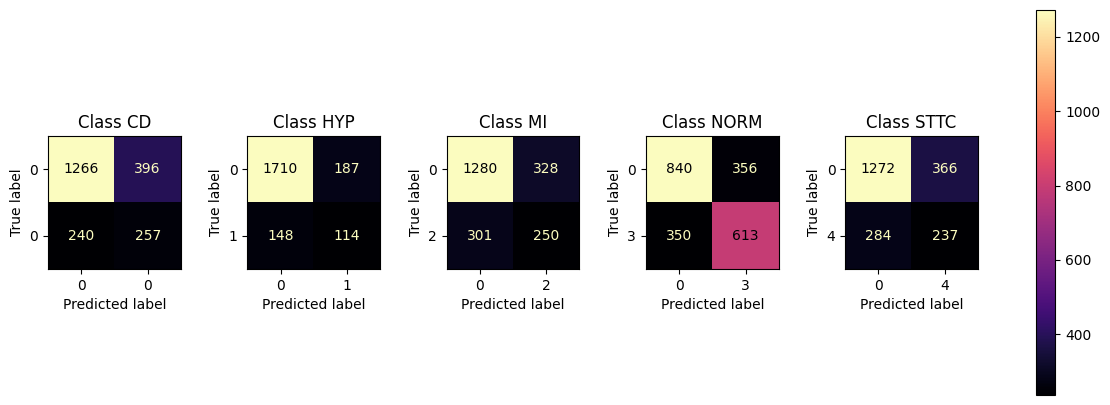

In [20]:
from scripts.data_evaluation import plot_confusion_matrix
import os

file_name = "confusion_matrix.png"
output_directory = f"saved_images/mlknn/"
if not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

plot_confusion_matrix(
    y_test,
    y_pred_mlknn,
    multi_label_binarizer.classes_,
    file_path=os.path.join(output_directory, file_name),
)

In [21]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, y_pred_mlknn, target_names=list(multi_label_binarizer.classes_)
    )
)

              precision    recall  f1-score   support

          CD       0.39      0.52      0.45       497
         HYP       0.38      0.44      0.40       262
          MI       0.43      0.45      0.44       551
        NORM       0.63      0.64      0.63       963
        STTC       0.39      0.45      0.42       521

   micro avg       0.47      0.53      0.50      2794
   macro avg       0.45      0.50      0.47      2794
weighted avg       0.48      0.53      0.50      2794
 samples avg       0.49      0.53      0.49      2794



In [22]:
import pandas as pd

mlknn_report = classification_report(
    y_test,
    y_pred_mlknn,
    target_names=list(multi_label_binarizer.classes_),
    output_dict=True,
)
df = pd.DataFrame(mlknn_report).transpose().round(decimals=3)
df.to_csv(f"saved_data/mlknn/classification_report.csv")